In [27]:
import os
import json
from urllib.parse import urlparse
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tld import get_fld
import pandas as pd
from IPython.display import display
from collections import Counter, defaultdict
import dns.resolver
import tldextract

# PREP

In [29]:
# 3 - table for most prevalent domains + isTracker
def get_tracking_domains_list():
    with open('disconnect-tracking-services.json', 'r') as f:
        tracking_services = json.load(f)

    all_tracker_domains = set()
    for category in tracking_services['categories'].values():
        for org in category:
            for url in org.values():
                for domains in url.values():
                    all_tracker_domains.update(domains)
    return list(all_tracker_domains)

TRACKING_DOMAINS = get_tracking_domains_list()
PERMISSIONS = [
    "accelerometer",
    "ambient-light-sensor",
    "attribution-reporting",
    "autoplay",
    "bluetooth",
    "browsing-topics",
    "camera",
    "compute-pressure",
    "cross-origin-isolated",
    "display-capture",
    "document-domain",
    "encrypted-media",
    "fullscreen",
    "geolocation",
    "gyroscope",
    "hid",
    "identity-credentials-get",
    "idle-detection",
    "local-fonts",
    "magnetometer",
    "microphone",
    "midi",
    "otp-credentials",
    "payment",
    "picture-in-picture",
    "publickey-credentials-create",
    "publickey-credentials-get",
    "screen-wake-lock",
    "serial",
    "storage-access",
    "usb",
    "web-share",
    "window-management",
    "xr-spatial-tracking"
]


# EXTRACT ALL NECESSARY DATA FROM HAR FILES IN ONE ITERATION

## Helpers

In [30]:
RESPONSE_CODES = [301,308,302,303,307]

def get_all_info_from_entries(entries, filename, all_redirection_pairs):  # gov_domain was acm from acm.nl (split(.)), is it ok to use acm.nl and split(_)? TODO
	# for 1, 2, 3
	distinct_third_party_domains = {}
	num_third_party_requests = 0

	# for 4
	num_get_reqs = 0
	num_post_reqs = 0
	num_other_reqs = 0

	# for 5
	disabled_permissions_per_url = set()

	# for 6
	referrers_per_url = set()

	# for 7
	accept_ch_hints = {}
	visited_hints_in_website = []

	# for 9
	first_party_subdomains = set()

	for entry in entries:
		# for 1, 2, 3 
		num_third_party_requests, distinct_third_party_domains = get_third_party_domain_counts(entry, filename, distinct_third_party_domains, num_third_party_requests)
		
		# for 4
		if entry['request']['method'] == "GET":
			num_get_reqs += 1
		elif entry['request']['method'] == "POST":
			num_post_reqs += 1
		else:
			num_other_reqs += 1

		# 5 permissions policy
		disabled_permissions = analyze_permissions_policy(entry, filename)
		disabled_permissions_per_url.update(disabled_permissions)

		# 6 referrer policy
		entry_policy = analyze_referrer_policy(entry, filename)
		if entry_policy:
			referrers_per_url.add(entry_policy)

		# 7 - ch header
		accept_ch_hints, visited_hints_in_website = get_accept_ch_header_requests(entry, accept_ch_hints, visited_hints_in_website)

		# 8 - cross-domain redirections
		if entry['response']['status'] in RESPONSE_CODES:
			source = get_fld(entry['request']['url'])
			target = get_fld(entry['response']['redirectURL'])
			
			if is_cross_domain(source, target):
				all_redirection_pairs[(source, target)].add(filename)
         
		# 9 - CNAME
		# main_domain = "ad.nl"  # TODO  why ? for gov ad.nl,  different for news?
		# main_domain = filename.split('_')[0]
		request_url = entry["request"]["url"]
		hostname = urlparse(request_url).hostname
		if hostname and hostname != filename:
			domain = get_fld(request_url, fail_silently=True)
			if domain == filename:
				first_party_subdomains.add(hostname)

	return (
        num_third_party_requests, 
        distinct_third_party_domains, 
        num_get_reqs, 
        num_post_reqs, 
        num_other_reqs, 
        accept_ch_hints,
        all_redirection_pairs,
		first_party_subdomains,
		disabled_permissions_per_url,
		referrers_per_url
        )


def is_cross_domain(url1, url2):
    return url1 != url2
	
	
def get_third_party_domain_counts(entry, gov_domain, distinct_third_party_domains, num_third_party_requests):
	url = entry['request']['url']
	hostname = urlparse(url).hostname
	if hostname and gov_domain not in hostname:   # TODO?
		num_third_party_requests += 1
		tld_1 = get_fld(url, fail_silently=True)
		# print(gov_domain)
		# print(url)
		# print(tld_1)
		if tld_1:
			if tld_1 not in distinct_third_party_domains:
				distinct_third_party_domains[tld_1] = 0
			else: 
				distinct_third_party_domains[tld_1] += 1
	return num_third_party_requests, distinct_third_party_domains


def get_accept_ch_header_requests(entry, accept_ch_hints, visited_hints_in_website):
	headers = entry['response']['headers']
	for header in headers:
		if header['name'] == 'accept-ch':
			client_hints = header['value'].split(',')
			for hint in client_hints:
				hint = hint.strip()
				if hint in visited_hints_in_website:
					continue
				accept_ch_hints[hint] = accept_ch_hints.get(hint, 0) + 1
				visited_hints_in_website.append(hint)
	return accept_ch_hints, visited_hints_in_website


def analyze_permissions_policy(entry, filename):
	request_url = entry['request']['url']
	response_headers = entry['response']['headers']
	main_domain = os.path.basename(filename).split('_')[0]
	disabled_permissions = set()
	
	if main_domain in request_url:  # only for first-party requests
		for header in response_headers:
			if header['name'].lower() == 'permissions-policy':
				for permission_setting in header['value'].split(','):
					permission_setting = permission_setting.strip()
					for setting in permission_setting.split(';'):
						if '=' in setting:
							permission, policy = setting.split('=')
							permission = permission.strip()
							policy = policy.strip()
							parsed_policy = urlparse(policy).netloc    # if it is specified as url

							if permission in PERMISSIONS:
								# Count permissions disabled completely or partially: either ()/none/self or first party url
								if policy in ('()', "'none'", 'self', ):
									disabled_permissions.add(permission)
								
								elif parsed_policy == main_domain:
									disabled_permissions.add(permission)
	return disabled_permissions


def analyze_referrer_policy(entry, filename):
	response_headers = entry['response']['headers']
	main_domain = os.path.basename(filename).split('_')[0]
	disabled_permissions = set()
	request_url = entry['request']['url']

	if main_domain in request_url:  # only for first-party requests
		for header in response_headers:
			if header['name'].lower() == 'referrer-policy':
				return header['value'].lower()
	return None



## Main func

In [31]:
# ONE BIG FUNC FOR EVERYTHING
# gov_dir = '..\crawl_data_gov'
# news_dir = '..\crawl_data_news'
GOV_DIR = '../crawl_data_gov'
NEWS_DIR = '../crawl_data_news'
EXT = 'har'


def get_all_info_form_hars(directory):
    all_num_requests = []
    all_num_third_party_requests = []
    all_distinct_third_party_domains = []
    all_distinct_third_parties_count_per_site = []
    all_num_get_reqs = 0
    all_num_post_reqs = 0
    all_num_other_reqs = 0
    all_client_hints = []
    all_redirection_pairs = defaultdict(set)
    all_first_party_subdomains = set()
    all_disabled_permissions = {}
    all_referrer_policies = {
        'same-origin': [],
        'no-referrer': [],
        'unsafe-url': []
    }

    for file in os.listdir(directory):
        if file.endswith(EXT):
            with open(directory + '/' + file, 'r', encoding='utf-8') as har_file:
                har_data = json.load(har_file)
                entries = har_data['log']['entries']

                num_requests = len(entries)
                all_num_requests.append(num_requests)
                
                (
                    num_third_party_requests, 
                    distinct_third_party_domains, 
                    num_get_reqs, 
                    num_post_reqs, 
                    num_other_reqs, 
                    accept_ch_hints,
                    all_redirection_pairs,
                    first_party_subdomains, 
                    disabled_permissions_per_url,
                    referrer_policies_per_url) = get_all_info_from_entries(entries, file.split('_')[0], all_redirection_pairs)

                all_num_third_party_requests.append(num_third_party_requests)
                all_distinct_third_parties_count_per_site.append(len(distinct_third_party_domains))
                all_distinct_third_party_domains = dict(Counter(all_distinct_third_party_domains) + Counter(distinct_third_party_domains))                
                all_num_get_reqs += num_get_reqs
                all_num_post_reqs += num_post_reqs
                all_num_other_reqs += num_other_reqs
                all_client_hints.append(accept_ch_hints)
                all_first_party_subdomains.update(first_party_subdomains)
                for permission in disabled_permissions_per_url:
                    if permission in all_disabled_permissions:
                        all_disabled_permissions[permission] += 1
                    else:
                        all_disabled_permissions[permission] = 1

                for policy in referrer_policies_per_url:
                    if policy in all_referrer_policies:
                        all_referrer_policies[policy].append(file.split('_')[0])


    return (
        all_num_requests, 
        all_num_third_party_requests, 
        all_distinct_third_party_domains,
        all_distinct_third_parties_count_per_site,
        all_num_get_reqs, 
        all_num_post_reqs, 
        all_num_other_reqs, 
        all_client_hints,
        all_redirection_pairs, 
        all_first_party_subdomains,
        all_disabled_permissions,
        all_referrer_policies
    )


In [32]:
(
    num_requests_gov, 
    num_third_party_requests_gov, 
    distinct_third_party_domains_gov, 
    distinct_third_parties_count_per_site_gov,
    num_get_reqs_gov, 
    num_post_reqs_gov, 
    num_other_reqs_gov,
    client_hints_gov,
    redirection_pairs_gov,
    first_party_subdomains_gov,
    disabled_permissions_gov,
    all_referrer_policies_gov) = get_all_info_form_hars(GOV_DIR)

(
    num_requests_news, 
    num_third_party_requests_news, 
    distinct_third_party_domains_news,
    distinct_third_parties_count_per_site_news,
    num_get_reqs_news, 
    num_post_reqs_news, 
    num_other_reqs_news, 
    client_hints_news, 
    redirection_pairs_news,
    first_party_subdomains_news,
    disabled_permissions_news,
    all_referrer_policies_news) = get_all_info_form_hars(NEWS_DIR)

# STATS AND VIZUALIZATIONS

## 1 - BOXPOTS WITH SOME METRICS

In [33]:
def create_boxplot(data, title, x_label, y_label, x_ticks=["Government", "News"], filename="boxplot.png"):
    sns.set(rc={'figure.figsize': (10, 10)})
    sns.set(style="whitegrid")
    ax = sns.boxplot(data=data)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_xticklabels(x_ticks)
    ax.set_ylabel(y_label)
    plt.savefig(f'boxplots/{filename}')
    plt.show()

In [34]:
with open('crawl_data_gov_times') as f:
    times_gov_dict = json.load(f)

with open('crawl_data_news_times') as f:
    times_news_dict = json.load(f)

times_gov_list = [dict_val for dict_val in times_gov_dict.values()]
times_news_list = [dict_val for dict_val in times_news_dict.values()]


C:\Users\lukev\AppData\Local\Temp\ipykernel_14192\538456316.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


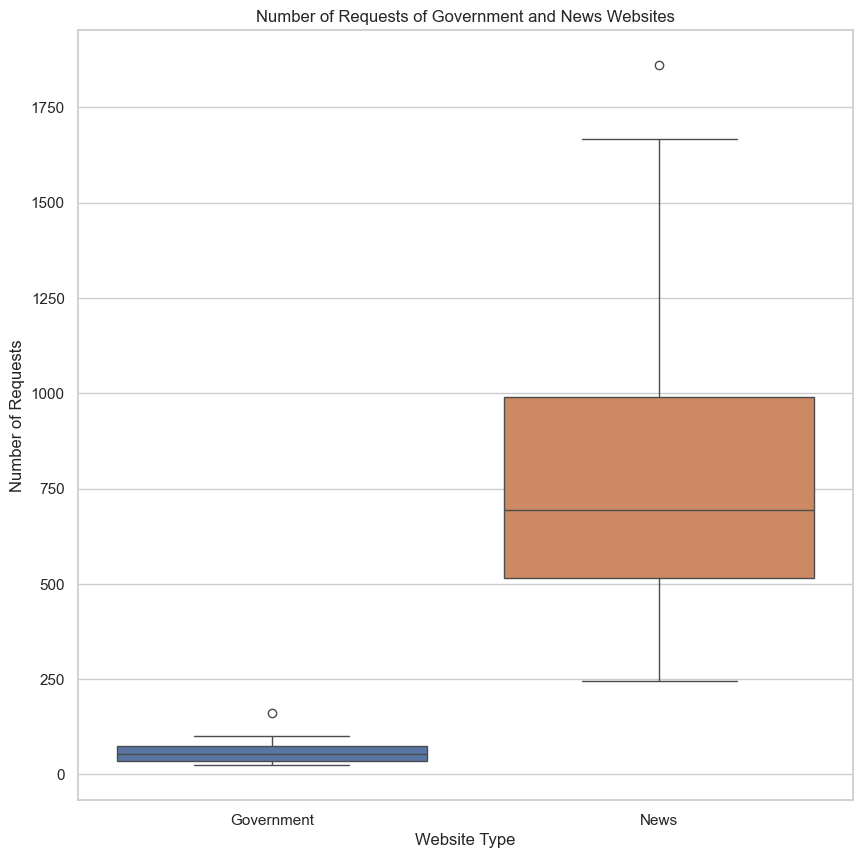

In [35]:
create_boxplot([num_requests_gov, num_requests_news], "Number of Requests of Government and News Websites", "Website Type", "Number of Requests", filename="gov_news_requests.png")

C:\Users\lukev\AppData\Local\Temp\ipykernel_14192\538456316.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


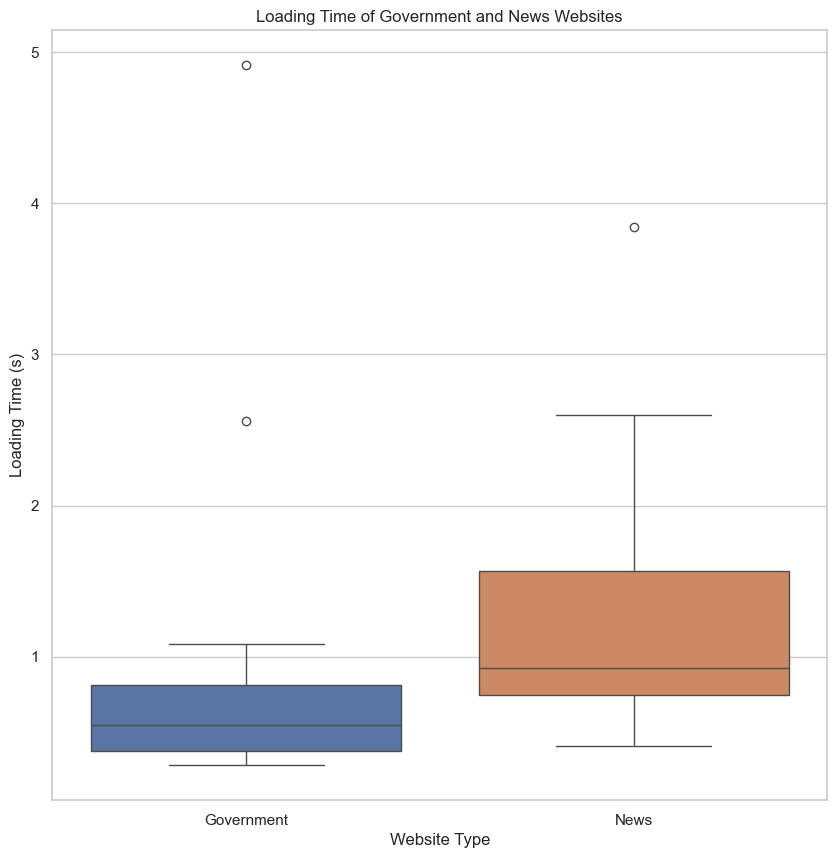

In [36]:
create_boxplot([times_gov_list, times_news_list], "Loading Time of Government and News Websites", "Website Type", "Loading Time (s)", filename="gov_news_loading_time.png")


C:\Users\lukev\AppData\Local\Temp\ipykernel_14192\538456316.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


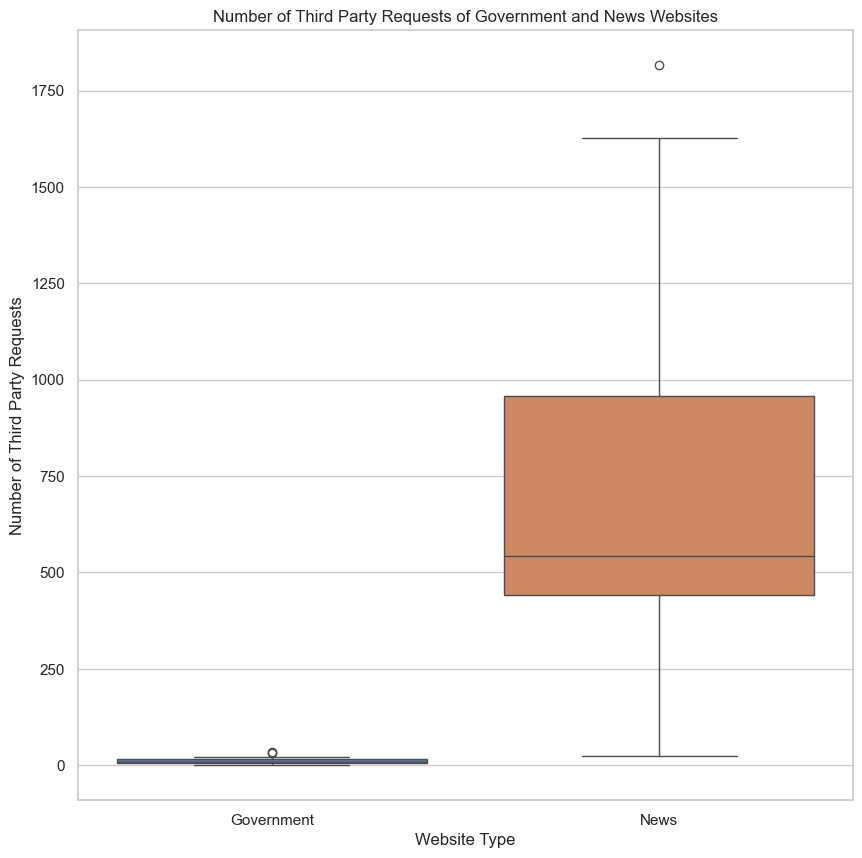

In [37]:
create_boxplot([num_third_party_requests_gov, num_third_party_requests_news], "Number of Third Party Requests of Government and News Websites", "Website Type", "Number of Third Party Requests", filename="gov_news_third_party_requests.png")

C:\Users\lukev\AppData\Local\Temp\ipykernel_14192\538456316.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks)


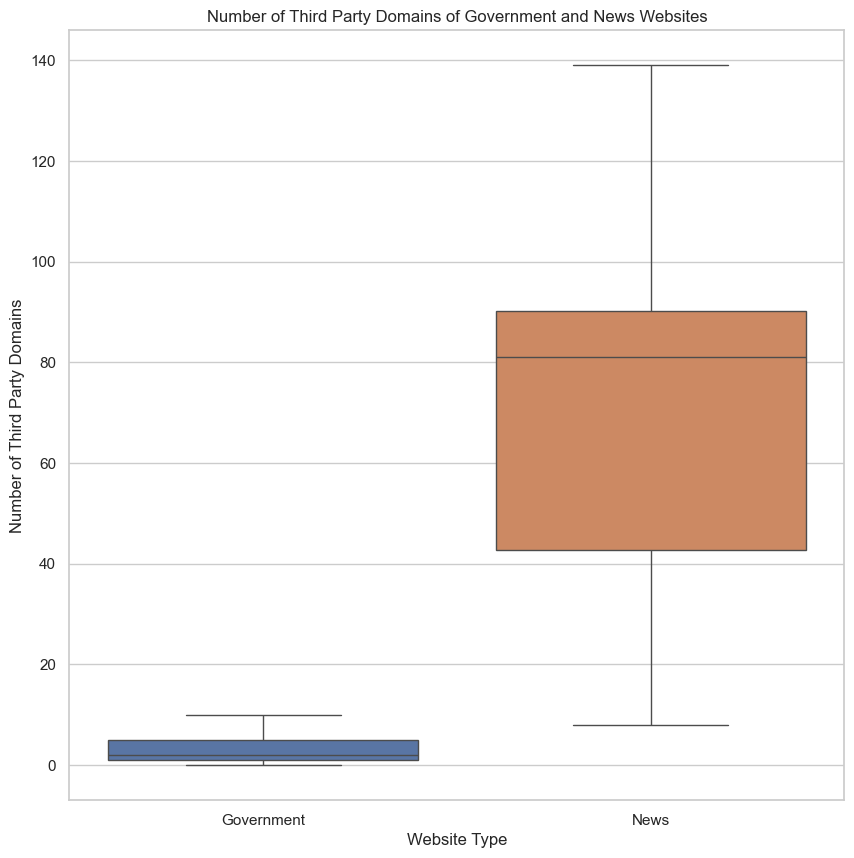

In [38]:

# TODO CHECK!!!!
create_boxplot([distinct_third_parties_count_per_site_gov, distinct_third_parties_count_per_site_news], "Number of Third Party Domains of Government and News Websites", "Website Type", "Number of Third Party Domains", filename="gov_news_third_party_domains.png")

## 2 - TABLE WITH MIN MEDIAN MAX FOR THE METRICS

In [39]:
metrics = {
    "loading_time": [times_gov_list, times_news_list], 
    "num_requests": [num_requests_gov, num_requests_news], 
    "num_third_party_requests": [num_third_party_requests_gov, num_third_party_requests_news], 
    "num_third_party_domains": [distinct_third_parties_count_per_site_gov, distinct_third_parties_count_per_site_news]
    }

for metric, values in metrics.items():
    print(f"Metric: {metric}")
    print('News:')
    print(f"Min: {min(values[1])}")
    print(f"Median: {sum(values[1]) / len(values[1])}")
    print(f"Max: {max(values[1])}")
    print('Government:')
    print(f"Min: {min(values[0])}")
    print(f"Median: {sum(values[0]) / len(values[0])}")
    print(f"Max: {max(values[0])}")


    # TODO PLEASE MAKE A TABLE IN CODE AS WELL!!!

Metric: loading_time
News:
Min: 0.4088881015777588
Median: 1.244267737865448
Max: 3.8423259258270264
Government:
Min: 0.2826869487762451
Median: 0.887889814376831
Max: 4.913503885269165
Metric: num_requests
News:
Min: 246
Median: 802.3
Max: 1861
Government:
Min: 24
Median: 58.1
Max: 162
Metric: num_third_party_requests
News:
Min: 24
Median: 683.8
Max: 1816
Government:
Min: 0
Median: 11.5
Max: 34
Metric: num_third_party_domains
News:
Min: 8
Median: 73.05
Max: 139
Government:
Min: 0
Median: 3.1
Max: 10


## 3 - TABLE WITH PREVALENT THIRD-PARTIES AND WHETHER THEY ARE CLASSIFIED AS A TRACKER

In [40]:
def prevalent_tracker_domains_table(third_party_entries):
    data = {
        'Third-party domain': list(third_party_entries.keys()), 
        'Number of distinct websites': list(third_party_entries.values()),    
    }
    table = pd.DataFrame(data)
    table = table.sort_values(by=['Number of distinct websites'], ascending=False, ignore_index=True)
    table['isTracker'] = table['Third-party domain'].apply(lambda x: True if x in TRACKING_DOMAINS else False)
    return table[:10]

In [41]:
tracker_table_news = prevalent_tracker_domains_table(distinct_third_party_domains_news)
tracker_table_news
# print(tracker_table_news.to_latex())

,Third-party domain,Number of distinct websites,isTracker
0,googlesyndication.com,1228,True
1,doubleclick.net,848,True
2,2mdn.net,575,True
3,taboola.com,473,True
4,pubmatic.com,413,True
5,corriereobjects.it,381,False
6,rubiconproject.com,362,True
7,adnxs.com,353,True
8,amazon-adsystem.com,309,True
9,gazzettaobjects.it,277,False


In [42]:
tracker_table_gov = prevalent_tracker_domains_table(distinct_third_party_domains_gov)
tracker_table_gov
# print(tracker_table_gov.to_latex())

,Third-party domain,Number of distinct websites,isTracker
0,piwik.pro,35,False
1,rijksoverheid.nl,20,False
2,siteimproveanalytics.io,16,False
3,abtasty.com,15,False
4,gstatic.com,10,True
5,cookiebot.com,7,False
6,uwv.nl,7,False
7,rijkscloud.nl,6,False
8,mopinion.com,6,False
9,google-analytics.com,5,True


## 4 - REQUESTS BY METHOD

In [43]:
data = {
    'HTTP Method': ['GET', 'POST', 'other'],
    'Crawl-news': [num_get_reqs_news, num_post_reqs_news, num_other_reqs_news],
    'Crawl-gov': [num_get_reqs_gov, num_post_reqs_gov, num_other_reqs_gov]
}

df = pd.DataFrame(data)
totals = df[['Crawl-gov', 'Crawl-news']].sum()

df['Crawl-gov %'] = (df['Crawl-gov'] / totals['Crawl-gov']) * 100
df['Crawl-news %'] = (df['Crawl-news'] / totals['Crawl-news']) * 100

df['Crawl-gov'] = df['Crawl-gov'].astype(str) + " (" + df['Crawl-gov %'].round(1).astype(str) + "%)"
df['Crawl-news'] = df['Crawl-news'].astype(str) + " (" + df['Crawl-news %'].round(1).astype(str) + "%)"
df = df.drop(columns=['Crawl-gov %', 'Crawl-news %'])

display(df.style.hide(axis='index'))

HTTP Method,Crawl-news,Crawl-gov
GET,14364 (89.5%),1087 (93.5%)
POST,1677 (10.5%),75 (6.5%)
other,5 (0.0%),0 (0.0%)


## 5 - PERMISSIONS POLICY

In [44]:
def make_permission_policy_table(permission_dict):
    df = pd.DataFrame(list(permission_dict.items()), columns=['Permission', 'Count'])

    # Sort by frequency and select top 10
    top10_df = df.nlargest(10, 'Count')

    # Modify rows to show 'permission: count'
    top10_df['Value'] = top10_df.apply(lambda row: f"{row['Permission']}: {row['Count']}", axis=1)

    # Select only the 'Value' column
    top10_df_result = top10_df[['Value']]
    return top10_df_result

permissions_news = make_permission_policy_table(disabled_permissions_news)
permissions_gov = make_permission_policy_table(disabled_permissions_gov)

combined_df = pd.concat([permissions_gov.reset_index(drop=True), permissions_news.reset_index(drop=True)], axis=1)
combined_df = combined_df.fillna(' ')
combined_df.columns = ['Number of websites where this permission was disabled (Crawl-gov)', 'Number of websites where this permission was disabled (Crawl-news)']


In [45]:
combined_df

,Number of websites where this permission was disabled (Crawl-gov),Number of websites where this permission was disabled (Crawl-news)
0,payment: 1,midi: 9
1,,magnetometer: 9
2,,usb: 9
3,,geolocation: 9
4,,xr-spatial-tracking: 9
5,,screen-wake-lock: 9
6,,microphone: 9
7,,encrypted-media: 9
8,,gyroscope: 9
9,,accelerometer: 9


## 6 - REFERRER POLICY

In [46]:
print(all_referrer_policies_gov)
print(all_referrer_policies_news)

{'same-origin': ['acm.nl', 'digid.nl', 'werk.nl'], 'no-referrer': ['business.gov.nl', 'denhaag.nl', 'werk.nl'], 'unsafe-url': []}
{'same-origin': ['nos.nl'], 'no-referrer': ['nos.nl', 'ouest-france.fr'], 'unsafe-url': ['corriere.it', 'gazzetta.it', 'repubblica.it']}


## 7 ACCEPT-CH ANALYSIS TABLE

In [ ]:
sorted_client_hints_news = {k: v for k, v in sorted(client_hints_news[0].items(), key=lambda item: item[1], reverse=True)}
sorted_client_hints_gov = {k: v for k, v in sorted(client_hints_gov[0].items(), key=lambda item: item[1], reverse=True)}

# Combine client hints from all websites
all_client_hints_gov = {}
for hints in client_hints_gov:
    for hint, count in hints.items():
        all_client_hints_gov[hint] = all_client_hints_gov.get(hint, 0) + count

# Sort client hints by count
sorted_all_client_hints_gov = {k: v for k, v in sorted(all_client_hints_gov.items(), key=lambda item: item[1], reverse=True)}

all_client_hints_news = {}
for hints in client_hints_news:
    for hint, count in hints.items():
        all_client_hints_news[hint] = all_client_hints_news.get(hint, 0) + count

sorted_all_client_hints_news = {k: v for k, v in sorted(all_client_hints_news.items(), key=lambda item: item[1], reverse=True)}

# Gov and news websites client hints combined
all_client_hints = {}
for hint, count in sorted_all_client_hints_gov.items():
    all_client_hints[hint] = all_client_hints.get(hint, 0) + count

for hint, count in sorted_all_client_hints_news.items():
    all_client_hints[hint] = all_client_hints.get(hint, 0) + count

sorted_all_client_hints = {k: v for k, v in sorted(all_client_hints.items(), key=lambda item: item[1], reverse=True)}

# Get 3 most common client hints
top_3_client_hints = list(sorted_all_client_hints.keys())[:3]
print(top_3_client_hints)

# Get counts for top 3 client hints
top_3_client_hints_counts = []
counts_gov = {}
counts_news = {}
for hint in top_3_client_hints: 
    counts_gov[hint] = sorted_all_client_hints_gov.get(hint, 0)
    counts_news[hint] = sorted_all_client_hints_news.get(hint, 0)
print(counts_gov)
print(counts_news)

['Sec-CH-UA-Arch', 'Sec-CH-UA-Bitness', 'Sec-CH-UA-Full-Version-List']
{'Sec-CH-UA-Arch': 1, 'Sec-CH-UA-Bitness': 1, 'Sec-CH-UA-Full-Version-List': 1}
{'Sec-CH-UA-Arch': 19, 'Sec-CH-UA-Bitness': 19, 'Sec-CH-UA-Full-Version-List': 19}


## 8 - PREVALENT REDIRECTION PAIRS

In [48]:
# pair_counts_gov = {pair: len(websites) for pair, websites in redirection_pairs_gov.items()}
# most_common_elements_gov = Counter(pair_counts_gov).most_common(3)

pair_counts_news = {pair: len(websites) for pair, websites in redirection_pairs_news.items()}
most_common_elements_news = Counter(pair_counts_news).most_common(3)

# Data is only available for news websites, since government websites don't have any cross-domain redirections
cross_domain_data = {
    'Source domain': [most_common_elements_news[0][0][0], most_common_elements_news[1][0][0], most_common_elements_news[2][0][0]],
    'Target domain': [most_common_elements_news[0][0][1], most_common_elements_news[1][0][1], most_common_elements_news[2][0][1]],
    'Number of distinct websites': [most_common_elements_news[0][1], most_common_elements_news[1][1], most_common_elements_news[2][1]]
}
cross_domain_df = pd.DataFrame(cross_domain_data)
display(cross_domain_df.style.hide(axis='index'))

Source domain,Target domain,Number of distinct websites
casalemedia.com,doubleclick.net,16
doubleclick.net,casalemedia.com,16
adnxs.com,doubleclick.net,12


## 9 - CNAME

In [49]:
# with open('..\domain_map.json', 'r', encoding='utf-8') as domain_map:
with open('./domain_map.json', 'r', encoding='utf-8') as domain_map:
    domain_map_data = json.load(domain_map)

gov_cname_records = []
news_cname_records = []
for gov_first_party_subdomain in first_party_subdomains_gov:
    try:
        answers = dns.resolver.resolve(gov_first_party_subdomain, 'CNAME')
        for rdata in answers:
            cname_record = rdata.target.to_text().rstrip(".")
            try:
                extracted = tldextract.extract(cname_record)
                main_domain = f"{extracted.domain}.{extracted.suffix}"
                cname_entity = domain_map_data[main_domain]['entityName']
            except:
                print("domain not found: " + cname_record)
                cname_entity = ""
            gov_cname_records.append((gov_first_party_subdomain, cname_record, cname_entity))
    except Exception as e:
        print(f"DNS error: {e}")

for news_first_party_subdomain in first_party_subdomains_gov:
    try:
        answers = dns.resolver.resolve(news_first_party_subdomain, 'CNAME')
        for rdata in answers:
            cname_record = rdata.target.to_text().rstrip(".")
            try:
                extracted = tldextract.extract(cname_record)
                main_domain = f"{extracted.domain}.{extracted.suffix}"
                cname_entity = domain_map_data[main_domain]['entityName']
            except:
                print("domain not found: " + cname_record)
                cname_entity = ""
            news_cname_records.append((news_first_party_subdomain, cname_record, cname_entity))
    except Exception as e:
        print(f"DNS error: {e}")

DNS error: The DNS response does not contain an answer to the question: www.cbs.nl. IN CNAME
domain not found: ps1.platformrijksoverheid.nl
DNS error: The DNS response does not contain an answer to the question: download.belastingdienst.nl. IN CNAME
domain not found: www.amsterdam.nl.cdn.cloudflare.net
DNS error: The DNS response does not contain an answer to the question: www.belastingdienst.nl. IN CNAME
DNS error: The DNS response does not contain an answer to the question: pwa001.belastingdienst.nl. IN CNAME
DNS error: The DNS response does not contain an answer to the question: www.denhaag.nl. IN CNAME
DNS error: The DNS response does not contain an answer to the question: www.digid.nl. IN CNAME
DNS error: The DNS response does not contain an answer to the question: statistics.ind.nl. IN CNAME
DNS error: The DNS response does not contain an answer to the question: login.werk.nl. IN CNAME
DNS error: The DNS response does not contain an answer to the question: www.uwv.nl. IN CNAME
DN

In [50]:
gov_cname_data = {
    'First-party subdomain': [cname_record[0] for cname_record in gov_cname_records],
    'CNAME record': [cname_record[1] for cname_record in gov_cname_records],
    'CNAME entity': [cname_record[2] for cname_record in gov_cname_records]
}
gov_cname_df = pd.DataFrame(gov_cname_data)
display(gov_cname_df.style.hide(axis='index'))

news_cname_data = {
    'First-party subdomain': [cname_record[0] for cname_record in news_cname_records],
    'CNAME record': [cname_record[1] for cname_record in news_cname_records],
    'CNAME entity': [cname_record[2] for cname_record in news_cname_records]
}
news_cname_df = pd.DataFrame(news_cname_data)
display(news_cname_df.style.hide(axis='index'))

First-party subdomain,CNAME record,CNAME entity
www.royal-house.nl,ps1.platformrijksoverheid.nl,
cdn.cbs.nl,cbs-nl-cdn.azureedge.net,Microsoft Corporation
www.amsterdam.nl,www.amsterdam.nl.cdn.cloudflare.net,
dap.amsterdam.nl,amsterdam.piwik.pro,Piwik PRO Sp. z o.o.
adobe-analytics-dc.belastingdienst.nl,wdbvhtupcp.data.adobedc.net,Adobe Inc.
statistiek.rijksoverheid.nl,rijksoverheid.piwik.pro,Piwik PRO Sp. z o.o.
tag2.uwv.nl,uwv.containers.piwik.pro,Piwik PRO Sp. z o.o.
cdn-extern.uwv.nl,cs1680.wpc.alphacdn.net,Verizon
statistiek.rvo.nl,rvo.piwik.pro,Piwik PRO Sp. z o.o.
www.government.nl,government.nl,


First-party subdomain,CNAME record,CNAME entity
www.royal-house.nl,ps1.platformrijksoverheid.nl,
cdn.cbs.nl,cbs-nl-cdn.azureedge.net,Microsoft Corporation
www.amsterdam.nl,www.amsterdam.nl.cdn.cloudflare.net,
dap.amsterdam.nl,amsterdam.piwik.pro,Piwik PRO Sp. z o.o.
adobe-analytics-dc.belastingdienst.nl,wdbvhtupcp.data.adobedc.net,Adobe Inc.
statistiek.rijksoverheid.nl,rijksoverheid.piwik.pro,Piwik PRO Sp. z o.o.
tag2.uwv.nl,uwv.containers.piwik.pro,Piwik PRO Sp. z o.o.
cdn-extern.uwv.nl,cs1680.wpc.alphacdn.net,Verizon
statistiek.rvo.nl,rvo.piwik.pro,Piwik PRO Sp. z o.o.
www.government.nl,government.nl,
